# Wi-Fi Fingerprinting

## Import modules and set up the environment

In [1]:
%matplotlib inline

import getopt                                         # C-style parser for command line options
import os                                             # Miscellaneous operating system interfaces

import sys                                            # System-specific parameters and functions
import math                                           # Mathematical functions
import time                                           # Time access and conversions

import numpy as np                                    # NumPy
import scipy as sp                                    # SciPy
import pandas as pd                                   # Pandas
pd.set_option('display.max_rows', 10000)              # Increase Pandas maximum rows display

import matplotlib.pyplot as plt                       # Matplotlib
import seaborn as sns                                 # Seaborn
sns.despine()                                         # Removing spines

from sklearn import preprocessing                     # scikit-learn preprocessing data
from sklearn.model_selection import GridSearchCV      # scikit-learn model selection GridSearchCV
from sklearn.model_selection import train_test_split  # scikit-learn model selection train_test_split
from sklearn.metrics import classification_report     # scikit-learn metrics classification_report

### Load the model classes

A class responsible for loading a JSON file (or all the JSON files in a given directory) into a Python dictionary

In [2]:
from yanux.cruncher.model.loader import JsonLoader

A class that takes a set of Python dictionaries containing Wi-Fi logging data loaded from JSON files collected by the YanuX Scavenger Android application

In [3]:
from yanux.cruncher.model.wifi import WifiLogs

Some general helper functions

In [4]:
from yanux.cruncher.ml.experiments import *

## Initialize Input & Output Data Directories and other parameters

In [5]:
input_data_directory = "data"
output_data_directory = "out"

print("Input Data Directory is:", input_data_directory)
print("Output Data Directory is", output_data_directory)

Input Data Directory is: data
Output Data Directory is out


### Create the output directory if it doesn't exist

In [6]:
if not os.path.exists(output_data_directory):
    os.makedirs(output_data_directory)

## Load Data from the Input Data Directory

Load all files from the *data* folder.
The logs currently placed there were collected using the **Yanux Scavenger** Android application on April 28<sup>th</sup>, 2016 using an LG Nexus 5 running Androdid Marshmallow 6.0.1

In [7]:
json_loader = JsonLoader(input_data_directory+"/wifi-fingerprints")
wifi_logs = WifiLogs(json_loader.json_data)

## Wi-Fi Readings

Number of Recorded Samples per Location

In [8]:
num_samples_per_location = int(len(wifi_logs.wifi_samples()) / len(wifi_logs.locations))
num_samples_per_location

40

Store the data into a Pandas Dataframe, in which each Wi-Fi result reading is represented by a single line

In [9]:
wifi_results_columns = ["filename", "place", "floor", "x", "y", "orientation", "sample_id", "mac_address",
                        "timestamp", "signal_strength"]

wifi_results = pd.DataFrame(wifi_logs.wifi_results(), columns=wifi_results_columns)
wifi_results.to_csv(output_data_directory + "/wifi_results.csv")

Identify the unique MAC Addresses present in the recorded data. Each one represents a single Wi-Fi Access Point.

In [10]:
mac_addresses = wifi_results.mac_address.unique()

Similarly, store the data into a Pandas Dataframe in which each line represents a single sampling cycle with *n* different readings for each of the Access Points within range. Those readings are stored as columns along each sample.

In [11]:
wifi_samples_columns = ["filename", "place", "floor", "x", "y", "orientation", "sample_id", "timestamp"]
wifi_samples_columns.extend(mac_addresses)

wifi_samples = pd.DataFrame(wifi_logs.wifi_samples(), columns=wifi_samples_columns)
wifi_samples = wifi_samples.sort_values(["filename", "x", "y", "floor", "sample_id"]).reset_index(drop=True)
wifi_samples.to_csv(output_data_directory + "/wifi_samples.csv")
wifi_samples

,filename,place,floor,x,y,orientation,sample_id,timestamp,00:15:f9:6c:7a:e1,00:15:f9:6c:7a:e0,...,00:15:f9:6c:7d:20,00:0f:60:06:71:2e,00:1b:fc:22:43:4e,00:12:43:f1:c4:41,00:12:43:f1:c4:40,00:12:43:f1:c4:42,bc:14:01:9c:37:08,bc:14:01:9c:37:09,30:8d:99:64:aa:8d,b0:5b:67:c2:a0:16
0,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,0,1461864822344,-71.0,-71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,1,1461864822344,-58.0,-58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,2,1461864822344,-61.0,-61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,3,1461864822344,-64.0,-65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,4,1461864822344,-65.0,-65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,5,1461864822344,-63.0,-63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,6,1461864822344,-61.0,-62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,7,1461864822344,-62.0,-61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,8,1461864822344,-61.0,-61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"left-to-right-point(0.25,0.75).json",ed2.fct.unl.pt,2,0.25,0.75,33.281586,9,1461864822344,-60.0,-58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Set Statistics

Number of Results

In [12]:
len(wifi_results)

17346

Number of Unique Mac Addresses

In [13]:
len(wifi_results.mac_address.unique())

39

Signal Strength Mean

In [14]:
wifi_results.signal_strength.mean()

-71.82163034705408

Signal Strength Standard Deviation

In [15]:
wifi_results.signal_strength.std()

12.106860904564376

Signal Strength Min

In [16]:
wifi_results.signal_strength.min()

-92

Signal Strength Max

In [17]:
wifi_results.signal_strength.max()

-37

### How often has each Access Point been detected

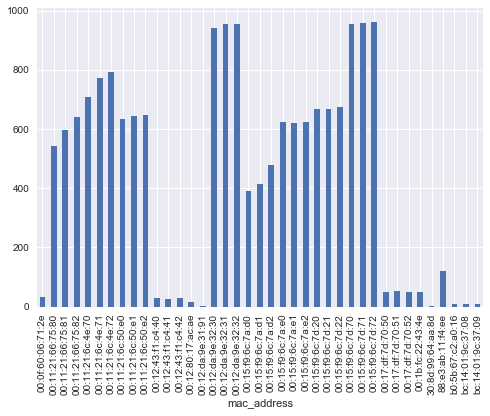

In [18]:
wifi_results_mac_address_group = wifi_results.groupby("mac_address")
wifi_results_mac_address_group.size().plot(kind="bar")

In [19]:
wifi_results_mac_address_group.size()

mac_address
00:0f:60:06:71:2e     33
00:11:21:66:75:80    544
00:11:21:66:75:81    595
00:11:21:66:75:82    639
00:11:21:6c:4e:70    709
00:11:21:6c:4e:71    771
00:11:21:6c:4e:72    792
00:11:21:6c:50:e0    635
00:11:21:6c:50:e1    643
00:11:21:6c:50:e2    647
00:12:43:f1:c4:40     30
00:12:43:f1:c4:41     27
00:12:43:f1:c4:42     30
00:12:80:17:ac:ae     17
00:12:da:9e:31:91      2
00:12:da:9e:32:30    940
00:12:da:9e:32:31    953
00:12:da:9e:32:32    955
00:15:f9:6c:7a:d0    392
00:15:f9:6c:7a:d1    413
00:15:f9:6c:7a:d2    479
00:15:f9:6c:7a:e0    622
00:15:f9:6c:7a:e1    619
00:15:f9:6c:7a:e2    622
00:15:f9:6c:7d:20    669
00:15:f9:6c:7d:21    668
00:15:f9:6c:7d:22    675
00:15:f9:6c:7d:70    956
00:15:f9:6c:7d:71    959
00:15:f9:6c:7d:72    962
00:17:df:7d:70:50     48
00:17:df:7d:70:51     53
00:17:df:7d:70:52     49
00:1b:fc:22:43:4e     50
30:8d:99:64:aa:8d      3
88:e3:ab:11:f4:ee    119
b0:5b:67:c2:a0:16     10
bc:14:01:9c:37:08      8
bc:14:01:9c:37:09      8
dtype: int64

In [20]:
wifi_results_mac_address_group.size().mean()

444.7692307692308

In [21]:
wifi_results_mac_address_group.size().max()

962

In [22]:
wifi_results_mac_address_group.size().min()

2

### How many Wi-Fi results were gathered at each location

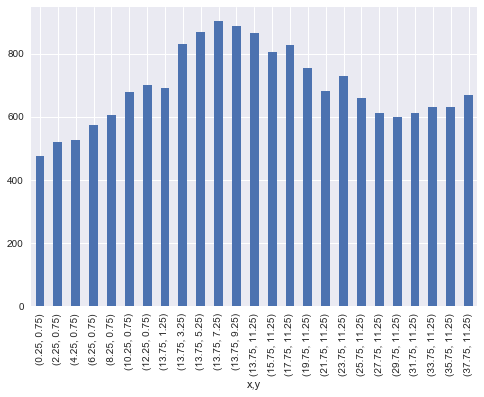

In [23]:
wifi_results_coord_group = wifi_results.groupby(["x", "y"])
wifi_results_coord_group.size().plot(kind="bar")

In [24]:
wifi_results_coord_group.size()

x      y    
0.25   0.75     475
2.25   0.75     520
4.25   0.75     527
6.25   0.75     575
8.25   0.75     606
10.25  0.75     679
12.25  0.75     700
13.75  1.25     691
       3.25     831
       5.25     869
       7.25     903
       9.25     887
       11.25    866
15.75  11.25    805
17.75  11.25    828
19.75  11.25    754
21.75  11.25    683
23.75  11.25    729
25.75  11.25    661
27.75  11.25    612
29.75  11.25    601
31.75  11.25    612
33.75  11.25    632
35.75  11.25    632
37.75  11.25    668
dtype: int64

## How many APs were detected at each location

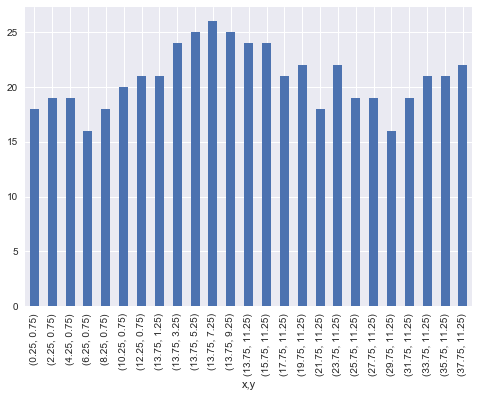

In [25]:
wifi_ap_per_location = wifi_samples.groupby(["x","y"]).min()[wifi_results_mac_address_group.size().keys()].count(axis=1)
wifi_ap_per_location.plot(kind="bar")

In [26]:
wifi_ap_per_location

x      y    
0.25   0.75     18
2.25   0.75     19
4.25   0.75     19
6.25   0.75     16
8.25   0.75     18
10.25  0.75     20
12.25  0.75     21
13.75  1.25     21
       3.25     24
       5.25     25
       7.25     26
       9.25     25
       11.25    24
15.75  11.25    24
17.75  11.25    21
19.75  11.25    22
21.75  11.25    18
23.75  11.25    22
25.75  11.25    19
27.75  11.25    19
29.75  11.25    16
31.75  11.25    19
33.75  11.25    21
35.75  11.25    21
37.75  11.25    22
dtype: int64

In [27]:
wifi_ap_per_location.mean()

20.8

In [28]:
wifi_ap_per_location.min()

16

In [29]:
wifi_ap_per_location.max()

26

### The coordinates of the points where data was captured

(-1.625, 39.625, 0.22499999999999998, 11.775)

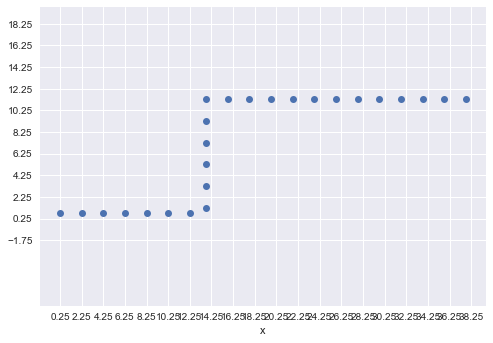

In [30]:
coords = wifi_results[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_plot_size = (min(coords["x"].min(),coords["y"].min())-2, max(coords["x"].max(),coords["y"].max())+2)
coords.plot(x="x",y="y", style="o", grid=True, legend=False,
            xlim=coords_plot_size, ylim=coords_plot_size,
            xticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2),
            yticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2)).axis('equal')

### Signal Strength Distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000263657A2DA0>]], dtype=object)

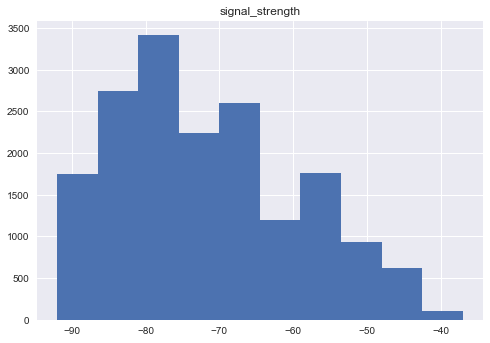

In [31]:
wifi_results.hist(column="signal_strength")

## Generate Train and Test Scenario

In [32]:
raw = True
groupby_mean = False
groupby_max = False
groupby_min = False
data_partials = [0.5]
test_data_partials = [0.5]
subset_locations_values = [0.5]
filename_prefixes = ["left-to-right-point", "right-to-left-point"]

In [33]:
print("Generating Training and Test Scenarios...")

data_scenarios = {}
test_data_scenarios = {}

# ---- Data Split Scenarios ---- #
partial_data_scenarios = {}
prepare_partial_data_scenarios(wifi_samples, partial_data_scenarios,
                               slice_at_the_end=False,
                               raw=raw,
                               groupby_mean=groupby_mean,
                               groupby_max=groupby_max,
                               groupby_min=groupby_min,
                               partials=data_partials)
partial_test_data_scenarios = {}
prepare_partial_data_scenarios(wifi_samples, partial_test_data_scenarios,
                               slice_at_the_end=True,
                               raw=raw,
                               groupby_mean=groupby_mean,
                               groupby_max=groupby_max,
                               groupby_min=groupby_min,
                               partials=test_data_partials)

data_scenarios.update(partial_data_scenarios)
test_data_scenarios.update(partial_test_data_scenarios)
# -------- #

# ---- Orientation Split Scenarios ---- #
filename_startswith_data_scenarios = {}
for filename_prefix in filename_prefixes:
    prepare_filename_startswith_data_scenarios(wifi_samples, filename_startswith_data_scenarios,
                                               raw=raw,
                                               groupby_mean=groupby_mean,
                                               groupby_max=groupby_max,
                                               groupby_min=groupby_min,
                                               filename_startswith=filename_prefix)
filename_startswith_test_data_scenarios = {}
for filename_prefix in filename_prefixes:
    prepare_filename_startswith_data_scenarios(wifi_samples, filename_startswith_test_data_scenarios,
                                               raw=raw,
                                               groupby_mean=groupby_mean,
                                               groupby_max=groupby_max,
                                               groupby_min=groupby_min,
                                               filename_startswith=filename_prefix)

data_scenarios.update(filename_startswith_data_scenarios)
test_data_scenarios.update(filename_startswith_test_data_scenarios)
# -------- #

# ---- Subset Locations Scenarios ---- #
subset_locations_data_scenarios = {}
subset_locations_test_data_scenarios = {}

for subset_locations in subset_locations_values:
    split_locations_wifi_samples = subset_wifi_samples_locations(wifi_samples, subset_locations)
    
    prepare_full_data_scenarios(split_locations_wifi_samples[0],
                                subset_locations_data_scenarios,
                                raw=raw,
                                groupby_mean=groupby_mean,
                                groupby_max=groupby_max,
                                groupby_min=groupby_min,
                                scenarios_suffix="subset_locations=" + str(subset_locations))
    
    prepare_full_data_scenarios(split_locations_wifi_samples[1],
                                subset_locations_data_scenarios,
                                raw=raw,
                                groupby_mean=groupby_mean,
                                groupby_max=groupby_max,
                                groupby_min=groupby_min,
                                scenarios_suffix="subset_locations=" + str(subset_locations))

data_scenarios.update(subset_locations_data_scenarios)
test_data_scenarios.update(subset_locations_test_data_scenarios)
# -------- #

# Data Scenarios using sklearn's train_test_split
loc_coords = ["x", "y", "floor"]
X = wifi_samples[mac_addresses].copy()
y = wifi_samples[loc_coords].copy()
y["label"] = "(" + y.x.map(str) + ", " + y.y.map(str) + ", " + y.floor.map(str) + ")"

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y[loc_coords],
                                                    test_size=0.5,
                                                    stratify=y["label"].values,
                                                    random_state=0)

if raw or groupby_mean or groupby_max or groupby_min:
    #train data
    train_split_data = pd.concat([y_train, X_train], axis=1).reset_index(drop=True)
    #test data
    test_split_data = pd.concat([y_test, X_test], axis=1).reset_index(drop=True)
    if raw:
        #train data
        data_scenarios["train_test_split_data"] = train_split_data
        #test data
        test_data_scenarios["train_test_split_data"] = test_split_data
    if groupby_mean or groupby_max or groupby_min:
        #train data
        train_split_groupby_data = train_split_data.groupby(loc_coords, as_index=False)
        #test data
        test_split_groupby_data = test_split_data.groupby(loc_coords, as_index=False)
        if groupby_mean:
            #train data
            train_split_groupby_mean_data = train_split_groupby_data.mean()
            data_scenarios["train_test_split_mean_data"] = train_split_groupby_mean_data
            #test data
            test_split_groupby_mean_data = test_split_groupby_data.mean()
            data_scenarios["train_test_split_mean_data"] = test_split_groupby_mean_data
        if groupby_max:
            #train data
            train_split_groupby_max_data = train_split_groupby_data.max()
            data_scenarios["train_test_split_max_data"] = train_split_groupby_max_data
            #test data
            test_split_groupby_max_data = test_split_groupby_data.max()
            data_scenarios["train_test_split_max_data"] = test_split_groupby_max_data
        if groupby_min:
            #train data
            train_split_groupby_min_data = train_split_groupby_data.min()
            data_scenarios["train_test_split_min_data"] = train_split_groupby_min_data
            #test data
            test_split_groupby_min_data = test_split_groupby_data.min()
            data_scenarios["train_test_split_min_data"] = test_split_groupby_min_data

save_scenarios(data_scenarios, output_directory=output_data_directory, prefix="train_")
print("# Data Scenarios: " + str(len(data_scenarios)))
save_scenarios(test_data_scenarios, output_directory=output_data_directory, prefix="test_")
print("# Test Data Scenarios: " + str(len(test_data_scenarios)))
print("Scenarios Generated!")

Generating Training and Test Scenarios...
# Data Scenarios: 5
# Test Data Scenarios: 4
Scenarios Generated!


Set a train and test scenario to be used by default when testing.

In [34]:
default_data_scenario = data_scenarios["train_test_split_data"]
default_test_data_scenario = test_data_scenarios["train_test_split_data"]

## Playground

### Algorithm
Test if the different nearest neighbor search algorithms produce different results.

In [35]:
n_neighbors=5
weights="uniform"
metric="euclidean"
nan_filler=-100
algorithms = ["brute", "kd_tree", "ball_tree"]
leaf_sizes = range(10, 60, 10) 

curr_data = default_data_scenario.fillna(nan_filler)
curr_test_data = default_test_data_scenario.fillna(nan_filler)

# Just a metrics accumulator
metrics = []
for a in algorithms:
    for l in leaf_sizes:
        start_time = time.clock()
        results = knn_experiment(curr_data,
                                 mac_addresses,
                                 ["x", "y"],
                                 algorithm=a,
                                 leaf_size=l,
                                 n_neighbors=n_neighbors,
                                 weights=weights,
                                 metric=metric,
                                 test_data=curr_test_data)
        end_time = time.clock()
        curr_metrics = experiment_metrics(results)
        curr_metrics["algorithm"] = a
        curr_metrics["leaf_size"] = l
        curr_metrics["elapsed_time"] = end_time - start_time
        metrics.append(curr_metrics)

cols = ["algorithm", "leaf_size", "elapsed_time"] + list(curr_metrics.keys())[:-3]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-algorithm.csv")
metrics_table.sort_values(cols[3:])
#metrics_table.sort_values("elapsed_time")

,algorithm,leaf_size,elapsed_time,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
0,brute,10,0.231085,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
1,brute,20,0.214367,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
2,brute,30,0.227336,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
3,brute,40,0.215674,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
4,brute,50,0.229485,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
7,kd_tree,30,0.222134,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
8,kd_tree,40,0.227237,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
9,kd_tree,50,0.230927,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
12,ball_tree,30,0.233706,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0
13,ball_tree,40,0.232003,2.36812,1.432015,7.65456,1.581139,2.0,2.800000,4.4,5.2,0.0,8.0


### # Neighbors
Test how the *k* value influences performance metrics

In [36]:
n_neighbors=range(1,11,2)
weights="uniform"
metric="euclidean"
nan_filler=-100

curr_data = default_data_scenario.fillna(nan_filler)
curr_test_data = default_test_data_scenario.fillna(nan_filler)

# Just a metrics accumulator
metrics = []
for k in n_neighbors:
    curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                     mac_addresses,
                                                     ["x", "y"],
                                                     algorithm="brute",
                                                     n_neighbors=k,
                                                     weights=weights,
                                                     metric=metric,
                                                     test_data=curr_test_data))
    curr_metrics["k"] = k
    metrics.append(curr_metrics)

cols = ["k"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-n_neighbors.csv")
metrics_table.sort_values(cols[1:])

,k,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
4,9,2.306673,1.433424,7.371333,1.333333,2.0,3.111111,4.022222,5.333333,0.000000,8.000000
3,7,2.328291,1.406122,7.394163,1.428571,2.0,3.142857,4.028571,5.142857,0.000000,7.714286
2,5,2.368120,1.432015,7.654560,1.581139,2.0,2.800000,4.400000,5.200000,0.000000,8.000000
1,3,2.442529,1.475754,8.139444,1.809498,2.0,3.333333,4.666667,5.333333,0.000000,8.666667
0,1,2.774201,1.442210,9.772000,2.000000,2.0,4.000000,4.000000,6.000000,1.581139,10.000000


### Weights
Check whether the neighbors should have the same (*uniform*) or a weighted (*distance*-based) influence in the regression result.

In [37]:
n_neighbors=range(2,6,1)
weights=["uniform", "distance"]
metric="euclidean"
nan_filler=-100

curr_data = default_data_scenario.fillna(nan_filler)
curr_test_data = default_test_data_scenario.fillna(nan_filler)

# Just a metrics accumulator
metrics = []
for k in n_neighbors:
    for w in weights:
        curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                         mac_addresses,
                                                         ["x", "y"],
                                                         algorithm="brute",
                                                         n_neighbors=k,
                                                         weights=w,
                                                         metric=metric,
                                                         test_data=curr_test_data))
        curr_metrics["k"] = k
        curr_metrics["weights"] = w
        metrics.append(curr_metrics)

cols = ["k","weights"] + list(curr_metrics.keys())[:-2]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-weights.csv")
metrics_table.sort_values(cols[2:])

,k,weights,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
6,5,uniform,2.368120,1.432015,7.654560,1.581139,2.0,2.800000,4.400000,5.200000,0.000000,8.000000
7,5,distance,2.370314,1.427683,7.652589,1.581139,2.0,2.906951,4.384594,5.187524,0.000233,7.902449
4,4,uniform,2.400562,1.446846,7.851875,1.581139,2.0,3.000000,4.000000,5.000000,0.000000,9.000000
5,4,distance,2.401047,1.440068,7.834676,1.581139,2.0,3.013407,4.121946,5.062699,0.008701,8.976432
3,3,distance,2.440255,1.471127,8.114730,1.703107,2.0,3.308079,4.584211,5.332414,0.007886,8.648484
2,3,uniform,2.442529,1.475754,8.139444,1.809498,2.0,3.333333,4.666667,5.333333,0.000000,8.666667
0,2,uniform,2.445367,1.563672,8.420000,2.000000,2.0,3.000000,4.000000,6.000000,0.000000,10.000000
1,2,distance,2.454834,1.541192,8.396731,2.000000,2.0,3.030906,4.011583,5.991810,0.001954,10.000000


### Metric
Just test a few different distance metrics to assess if there is a better alternative than the plain old *euclidean* distance. The tested metrics include:
- Euclidean Distance
    - sqrt(sum((x - y)^2))
- Manhattan Distance
    - sum(|x - y|) 
- Chebyshev Distance
    - sum(max(|x - y|))
- Hamming Distance
    - N_unequal(x, y) / N_tot
- Canberra Distance
    - sum(|x - y| / (|x| + |y|))
- Braycurtis Similarity
    - sum(|x - y|) / (sum(|x|) + sum(|y|))
- S Euclidean Distance
    - sqrt(sum((x - y)^2 / V))
- Mahalanobis Distance
    - sqrt((x - y)' V^-1 (x - y))

The possible arguments are the following:
- p = The order of the norm of the difference
- V = array_like symmetric positive-definite covariance matrix.
- w = (N,) array_like weight vector.

In [38]:
n_neighbors=3
weights="uniform"
metric=[
        "euclidean","manhattan", "chebyshev",
        "hamming", "canberra", "braycurtis",
        #"seuclidean", "mahalanobis"
       ]
nan_filler=-100

curr_data = default_data_scenario.fillna(nan_filler)
curr_test_data = default_test_data_scenario.fillna(nan_filler)

# Just a metrics accumulator
metrics = []
for m in metric:
    if metric in ["mahalanobis", "seuclidean"]:
        metric_params = {'V': np.cov(curr_data[mac_addresses])}
    else:
        metric_params = None
    curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                     mac_addresses,
                                                     ["x", "y"],
                                                     algorithm="brute",
                                                     n_neighbors=n_neighbors,
                                                     weights=weights,
                                                     metric=m,
                                                     metric_params=metric_params,
                                                     test_data=curr_test_data))
    curr_metrics["metric"] = m
    metrics.append(curr_metrics)

cols = ["metric"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-metric.csv")
metrics_table.sort_values(cols[1:])

,metric,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
5,braycurtis,2.392339,1.421062,7.738667,2.000000,2.000000,3.333333,4.000000,4.666667,0.0,9.333333
1,manhattan,2.393280,1.430413,7.769778,1.885618,2.000000,3.333333,4.000000,4.666667,0.0,9.333333
4,canberra,2.437806,1.463918,8.081667,2.000000,2.000000,3.333333,4.000000,4.666667,0.0,9.333333
0,euclidean,2.442529,1.475754,8.139444,1.809498,2.000000,3.333333,4.666667,5.333333,0.0,8.666667
2,chebyshev,2.536648,1.662880,9.194222,1.581139,2.000000,3.333333,4.666667,6.000000,0.0,12.000000
3,hamming,3.084107,2.219390,14.427556,2.000000,2.666667,4.000000,6.000000,7.333333,0.0,18.000000


### NaN filler values
Test which is the signal strength value that should be considered for Access Points that are currently out of range. This is needed as part of the process of computing the distance/similarity between different fingerprints.

In [39]:
n_neighbors=3
weights="uniform"
metric="euclidean"
nan_filler = [-1000000, -100, 0, 100, 1000000,
              default_data_scenario[mac_addresses].min().min()-1] 

# Just a metrics accumulator
metrics = []
for nf in nan_filler:
    curr_data = default_data_scenario.fillna(nf)
    curr_test_data = default_test_data_scenario.fillna(nf)
    curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                     mac_addresses,
                                                     ["x", "y"],
                                                     algorithm="brute",
                                                     n_neighbors=n_neighbors,
                                                     weights=weights,
                                                     metric=metric,
                                                     test_data=curr_test_data))
    curr_metrics["nan_filler"] = nf
    metrics.append(curr_metrics)

cols = ["nan_filler"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-nan_filler.csv")
metrics_table.sort_values(cols[1:])

,nan_filler,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
5,-93.0,2.373887,1.340078,7.427556,2.000000,2.000000,3.069401,4.000000,4.666667,0.0,7.333333
1,-100.0,2.442529,1.475754,8.139444,1.809498,2.000000,3.333333,4.666667,5.333333,0.0,8.666667
3,100.0,2.694600,1.788785,10.454222,2.000000,2.000000,3.333333,5.333333,6.000000,0.0,11.333333
2,0.0,2.695563,1.749272,10.319889,2.000000,2.000000,3.333333,5.333333,6.000000,0.0,11.333333
4,1000000.0,2.739809,1.830644,10.851111,2.000000,2.000000,3.333333,5.333333,6.304838,0.0,11.333333
0,-1000000.0,2.741417,1.575485,9.992556,2.000000,2.223611,3.651650,4.666667,6.000000,0.0,11.333333


### Units
- dBm
- mW

In [40]:
n_neighbors=3
weights="uniform"
metric="euclidean"
nan_filler=-100

# Just a metrics accumulator
metrics = []

# Use the directly measured dBm values
curr_data = default_data_scenario.fillna(nan_filler)
curr_test_data = default_test_data_scenario.fillna(nan_filler)
curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                 mac_addresses,
                                                 ["x", "y"],
                                                 algorithm="brute",
                                                 n_neighbors=n_neighbors,
                                                 weights=weights,
                                                 metric=metric,
                                                 test_data=curr_test_data))
curr_metrics["units"] = "dBm"
metrics.append(curr_metrics)

# Convert to mW
curr_data[mac_addresses] = convert_to_units(curr_data[mac_addresses], from_units="dBm", to_units="mW")
curr_test_data[mac_addresses] = convert_to_units(curr_test_data[mac_addresses], from_units="dBm", to_units="mW")
curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                 mac_addresses,
                                                 ["x", "y"],
                                                 algorithm="brute",
                                                 n_neighbors=n_neighbors,
                                                 weights=weights,
                                                 metric=metric,
                                                 test_data=curr_test_data))
curr_metrics["units"] = "mW"
metrics.append(curr_metrics)

    
cols = ["units"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-units.csv")
metrics_table.sort_values(cols[1:])

,units,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
0,dBm,2.442529,1.475754,8.139444,1.809498,2.000000,3.333333,4.666667,5.333333,0.0,8.666667
1,mW,4.578686,3.341002,32.104333,2.000000,3.333333,6.000000,10.000000,11.333333,0.0,18.384776


### Scaler
Test different data scaling and normalization approaches to find out if any of them provides a clear advantage over the others.

In [41]:
n_neighbors=3
weights="uniform"
metric="euclidean"
nan_filler = -100

scaler_values = {
                    "None": None,
                    "MinMaxScaler": preprocessing.MinMaxScaler(),
                    "StandardScaler": preprocessing.StandardScaler(),
                    "RobustScaler": preprocessing.RobustScaler(),
                    "NormalizerEuclidean": preprocessing.Normalizer(norm="l2"),
                    "NormalizerManhattan": preprocessing.Normalizer(norm="l1")
                }

# Just a metrics accumulator
metrics = []
for scaler_name, scaler in scaler_values.items():
    curr_data = default_data_scenario.fillna(nan_filler)
    curr_test_data = default_test_data_scenario.fillna(nan_filler)
    if scaler is not None:
        scaler.fit(curr_data[mac_addresses])
        curr_data[mac_addresses] = pd.DataFrame(scaler.transform(curr_data[mac_addresses]),
                                                columns=mac_addresses)
        curr_test_data[mac_addresses] = pd.DataFrame(scaler.transform(curr_test_data[mac_addresses]),
                                                     columns=mac_addresses)
    curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                     mac_addresses,
                                                     ["x", "y"],
                                                     algorithm="brute",
                                                     n_neighbors=n_neighbors,
                                                     weights=weights,
                                                     metric=metric,
                                                     metric_params=metric_params,
                                                     test_data=curr_test_data))
    curr_metrics["scaler"] = scaler_name
    metrics.append(curr_metrics)

cols = ["scaler"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-scaler.csv")
metrics_table.sort_values(cols[1:])

,scaler,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
1,MinMaxScaler,2.353140,1.337776,7.323333,1.581139,2.0,3.333333,4.000000,4.666667,0.0,9.333333
2,StandardScaler,2.435177,1.376321,7.820556,1.971405,2.0,3.333333,4.000000,5.333333,0.0,8.000000
0,None,2.442529,1.475754,8.139444,1.809498,2.0,3.333333,4.666667,5.333333,0.0,8.666667
5,NormalizerManhattan,2.446346,1.499779,8.229444,1.809498,2.0,3.333333,4.261400,5.333333,0.0,8.666667
4,NormalizerEuclidean,2.448262,1.491464,8.214000,1.971405,2.0,3.333333,4.021637,5.333333,0.0,8.666667
3,RobustScaler,2.494463,1.409912,8.206222,2.000000,2.0,3.333333,4.000000,5.333333,0.0,9.333333


### Different Data Processing and Aggregation Scenarios
Testing different ways of processing offline and online data.

#### How does the amount of retrieved online data before affects positioning performance while considering the full offline data? And also, how do different agrregation strategies (i.e., mean, maximum and minimum signal strength per location) affect the results?

In [42]:
n_neighbors=3
weights="uniform"
metric="euclidean"
nan_filler=-100

curr_data_scenarios = {}
curr_data_scenarios.update(partial_data_scenarios)

curr_test_data_scenarios = {}
curr_test_data_scenarios.update(partial_test_data_scenarios)

# Just a metrics accumulator
metrics = []
for data_scenario_name, data_scenario in curr_data_scenarios.items():
    for test_data_scenario_name, test_data_scenario in curr_test_data_scenarios.items():
        curr_data = data_scenario.fillna(nan_filler)
        curr_test_data = test_data_scenario.fillna(nan_filler)
        curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                         mac_addresses,
                                                         ["x", "y"],
                                                         algorithm="brute",
                                                         n_neighbors=n_neighbors,
                                                         weights=weights,
                                                         metric=metric,
                                                         test_data=curr_test_data))
        curr_metrics["data_scenario"] = data_scenario_name
        curr_metrics["test_data_scenario"] = test_data_scenario_name
        metrics.append(curr_metrics)

cols = ["data_scenario", "test_data_scenario"] + list(curr_metrics.keys())[:-2]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-data_scenarios.csv")
metrics_table.sort_values(cols[2:])

,data_scenario,test_data_scenario,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
0,partial_data_fraction=0.5,partial_data_fraction=0.5,2.70318,1.531578,9.648222,2.0,2.0,4.0,4.666667,6.0,0.0,8.0


#### Does orientation affect the positioning performance?
Comparison between data collected when moving through the floor plan from left to right, top to bottom, and when moving in the opposite directions. 

In [43]:
n_neighbors=3
weights="uniform"
metric="euclidean"
nan_filler=-100

curr_data_scenarios = {}
curr_data_scenarios.update(filename_startswith_data_scenarios)

curr_test_data_scenarios = {}
curr_test_data_scenarios.update(filename_startswith_test_data_scenarios)

# Just a metrics accumulator
metrics = []
for data_scenario_name, data_scenario in curr_data_scenarios.items():
    for test_data_scenario_name, test_data_scenario in curr_test_data_scenarios.items():
        curr_data = data_scenario.fillna(nan_filler)
        curr_test_data = test_data_scenario.fillna(nan_filler)
        curr_metrics = experiment_metrics(knn_experiment(curr_data,
                                                         mac_addresses,
                                                         ["x", "y"],
                                                         algorithm="brute",
                                                         n_neighbors=n_neighbors,
                                                         weights=weights,
                                                         metric=metric,
                                                         test_data=curr_test_data))
        curr_metrics["data_scenario"] = data_scenario_name
        curr_metrics["test_data_scenario"] = test_data_scenario_name
        metrics.append(curr_metrics)

cols = ["data_scenario", "test_data_scenario"] + list(curr_metrics.keys())[:-2]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-data_scenarios.csv")
metrics_table.sort_values(cols[2:])

,data_scenario,test_data_scenario,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
0,filename_startswith_data_left-to-right-point,filename_startswith_data_left-to-right-point,2.203274,1.201214,6.294444,2.0,2.0,2.666667,4.000000,4.666667,0.0,8.000000
3,filename_startswith_data_right-to-left-point,filename_startswith_data_right-to-left-point,2.462262,1.420160,8.075556,2.0,2.0,3.333333,4.000000,6.000000,0.0,8.000000
2,filename_startswith_data_right-to-left-point,filename_startswith_data_left-to-right-point,2.602709,1.545212,9.157000,2.0,2.0,3.333333,4.666667,6.000000,0.0,9.333333
1,filename_startswith_data_left-to-right-point,filename_startswith_data_right-to-left-point,2.711180,1.527290,9.678444,2.0,2.0,4.000000,4.666667,6.000000,0.0,8.000000


### Grid Search - Searching for estimator parameters

In [44]:
k_neighbors_values = range(1,11)
weights_values = [
                    "uniform",
                    "distance"
                 ]
metric_values = [
                    "euclidean",
                    "manhattan",
                    "chebyshev",
                    "hamming",
                    "canberra", 
                    "braycurtis"
                ]
algorithm_values = [
                    "auto",
                    "brute",
                    "ball_tree",
                    #"kd_tree"
                   ]
leaf_size_values = range(10, 60, 10)
nan_filler = -100

param_grid = {
                "n_neighbors": list(k_neighbors_values),
                "weights": weights_values,
                "metric": metric_values,
                "algorithm": algorithm_values,
                "leaf_size": list(leaf_size_values)
              }
knn = KNeighborsRegressor()
grid = GridSearchCV(knn, param_grid=param_grid, cv=10, n_jobs=-1, error_score=0,
                    scoring=sklearn.metrics.make_scorer(sklearn.metrics.r2_score,
                                                        greater_is_better=True,
                                                        needs_proba=False,
                                                        needs_threshold=False,
                                                        multioutput="uniform_average"))
grid.fit(X_train.fillna(nan_filler), y_train[["x", "y"]])
print("Best parameters set found on development set:")
print(grid.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" %(mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'canberra', 'n_neighbors': 2, 'weights': 'distance'}
Grid scores on development set:
0.991 (+/-0.012) for {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.991 (+/-0.012) for {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.993 (+/-0.008) for {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.993 (+/-0.008) for {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.993 (+/-0.007) for {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.993 (+/-0.007) for {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.992 (+/-0.008) for {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidea

c:\developmenttools\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.971 (+/-0.019) for {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 5, 'weights': 'distance'}
0.968 (+/-0.021) for {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 6, 'weights': 'uniform'}
0.971 (+/-0.020) for {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 6, 'weights': 'distance'}
0.968 (+/-0.021) for {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 7, 'weights': 'uniform'}
0.971 (+/-0.020) for {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 7, 'weights': 'distance'}
0.968 (+/-0.023) for {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 8, 'weights': 'uniform'}
0.971 (+/-0.022) for {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 8, 'weights': 'distance'}
0.968 (+/-0.021) for {'algorithm': 'brute', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 9, 'weights': 'uniform'}
0.97

In [45]:
y_true, y_pred = y_test, grid.predict(X_test.fillna(-100))
#Only applicable to classifiers. I'm currently using regression!
#print(classification_report(y_true, y_pred))

predictions = pd.DataFrame(y_pred, columns=["x", "y"])
result = y_true.reset_index(drop=True).join(predictions, rsuffix="_predicted")
result["error"] = (predictions[["x", "y"]] - result[["x", "y"]]).apply(np.linalg.norm, axis=1)
metrics = experiment_metrics(result)
pd.DataFrame([metrics], columns=list(metrics.keys()))

,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
0,0.190854,0.562043,0.351685,0.0,1.776357e-15,3.552714e-15,0.954801,1.443351,0.0,4.0
